In [1]:
!pip install torchview

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import os
import certifi
import json
import torchvision
from torchview import draw_graph
from torchsummary import summary

In [3]:
os.environ['SSL_CERT_FILE'] = certifi.where()

data augmentation and normalization for training

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data normalization for testing

In [5]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

load dataset

In [6]:
data_path = './data_cifar/'
cifar10_train = CIFAR10(data_path, train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(data_path, train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:12<00:00, 13519956.79it/s]


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar/
Files already downloaded and verified


split trainset to train an validation sets

In [7]:
train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

define dataloaders

In [8]:
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

define model

In [9]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

initialize the model, loss function, and optimizer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

training function

In [11]:
def train(model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = running_loss / len(train_loader)
    return average_loss, accuracy

evaluate function

In [12]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = running_loss / len(data_loader)
    return average_loss, accuracy

create directory for saving model

In [13]:
os.makedirs('./model_checkpoints', exist_ok=True)

save configurations

In [14]:
config = {
    "batch_size": 128,
    "learning_rate": 0.001,
    "epochs": 50,
    "transform_train": str(transform_train),
    "transform_test": str(transform_test),
    "device": str(device)
}
with open('./model_checkpoints/config.json', 'w') as f:
    json.dump(config, f, indent=4)

training phase

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0

for epoch in range(config['epochs']):
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, epoch, device)
    val_loss, val_accuracy = evaluate(model, testloader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{config["epochs"]}]:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    torch.save(model.state_dict(), f'./model_checkpoints/model_epoch_{epoch+1}.pth')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), './model_checkpoints/best_model.pth')

Epoch [1/50]:
Train Loss: 1.4569, Train Accuracy: 46.51%
Validation Loss: 1.1986, Validation Accuracy: 57.73%
Epoch [2/50]:
Train Loss: 1.0475, Train Accuracy: 63.11%
Validation Loss: 0.9644, Validation Accuracy: 65.04%
Epoch [3/50]:
Train Loss: 0.8678, Train Accuracy: 69.92%
Validation Loss: 0.9072, Validation Accuracy: 68.61%
Epoch [4/50]:
Train Loss: 0.7519, Train Accuracy: 74.20%
Validation Loss: 0.7001, Validation Accuracy: 76.30%
Epoch [5/50]:
Train Loss: 0.6774, Train Accuracy: 76.69%
Validation Loss: 0.7057, Validation Accuracy: 76.08%
Epoch [6/50]:
Train Loss: 0.6184, Train Accuracy: 78.70%
Validation Loss: 0.7597, Validation Accuracy: 74.27%
Epoch [7/50]:
Train Loss: 0.5775, Train Accuracy: 80.29%
Validation Loss: 0.6191, Validation Accuracy: 78.81%
Epoch [8/50]:
Train Loss: 0.5389, Train Accuracy: 81.72%
Validation Loss: 0.6250, Validation Accuracy: 79.28%
Epoch [9/50]:
Train Loss: 0.4999, Train Accuracy: 83.13%
Validation Loss: 0.6007, Validation Accuracy: 79.66%
Epoch [10/

test phase

In [16]:
test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}',
      f'Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4480 Test Accuracy: 87.23%


check details

In [20]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

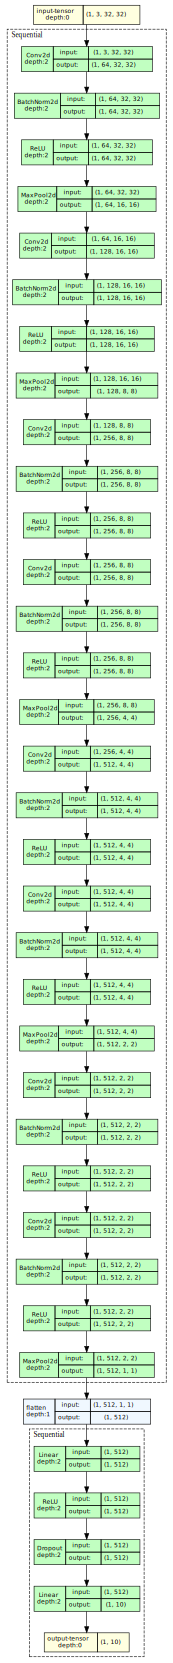

In [21]:
model_graph = draw_graph(model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

plotting

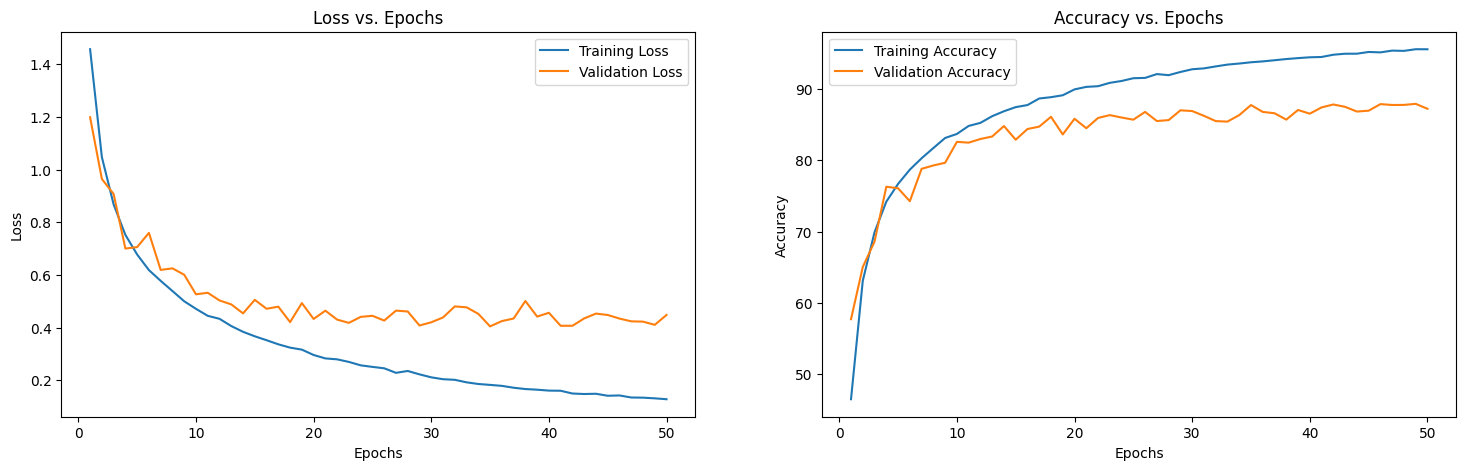

In [22]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, config['epochs']+1), train_losses, label='Training Loss')
plt.plot(range(1, config['epochs']+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, config['epochs']+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, config['epochs']+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()

download saved files

In [ ]:
from google.colab import files

In [ ]:
%cd /content

/content


In [ ]:
!zip -r model_checkpoints.zip model_checkpoints/

  adding: model_checkpoints/ (stored 0%)
  adding: model_checkpoints/model_epoch_15.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_17.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_38.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_45.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_18.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_31.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_21.pth (deflated 7%)
  adding: model_checkpoints/best_model.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_50.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_2.pth (deflated 8%)
  adding: model_checkpoints/model_epoch_47.pth (deflated 7%)
  adding: model_checkpoints/final_model.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_7.pth (deflated 8%)
  adding: model_checkpoints/model_epoch_40.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_12.pth (deflated 7%)
  adding: model_checkpoints/model_epoch_46.pth (defla

In [ ]:
files.download('model_checkpoints.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>